<a href="https://www.kaggle.com/code/sivamanivallabhani/bertfinetuning?scriptVersionId=176517063" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Regular imports
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np 
device = "cuda" if torch.cuda.is_available() else "cpu"

# Import torch.nn.functional as F
import torch.nn.functional as F

In [2]:
# Define data path
data_path = "/kaggle/input/olidv1/olid-training-v1.0.tsv"


In [3]:
# Load data
import pandas as pd
data = pd.read_csv(data_path, sep='\t')
df = pd.DataFrame(data)
df.columns = ['id', 'tweet', 'subtask_a', 'subtask_b', 'subtask_c']
df["classk"] = df["subtask_a"].map({"OFF":1, "NOT":0})  # Convert labels to binary (hate vs not hate)
tweets = df.tweet
res = []


In [4]:
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c,classk
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,1
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,1
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,1
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,0


In [5]:
# Process tweets
for i in range(len(tweets)):
    splitt = tweets[i].split("@USER")
    if len(splitt) == 1:
        res.append(splitt[0])
    else:
        res.append(splitt[-1])

tweets = res

In [6]:

# Import tokenizer and BERT model
from transformers import AutoTokenizer, BertModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
# Define custom dataset class
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __getitem__(self, index: int) -> (torch.Tensor, int):
        X = self.data[index]
        y = self.labels[index]
        return (X, y)
    
    def __len__(self) -> int:
        return len(self.data)


In [8]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets, list(df.classk), test_size=0.2, shuffle=True)

# Define train and test datasets and dataloaders
train_data = Custom_Dataset(data=X_train, labels=y_train)
test_data = Custom_Dataset(data=X_test, labels=y_test)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=3, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [9]:
class Model0(nn.Module):
    def __init__(self, model, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.model = model
        self.fc1 = nn.Linear(768, 256)  # Additional layer for fine-tuning
        self.fc2 = nn.Linear(256, 2)     # Output layer

    def forward(self, X):
        inputs = self.tokenizer(X, return_tensors="pt").to(device)
        outputs = self.model(**inputs)
        outputs = outputs.last_hidden_state[0][0].unsqueeze(1)

        
        # Additional layers for fine-tuning
        outputs = torch.relu(self.fc1(outputs.squeeze()))  # Remove extra dimension
        outputs = self.fc2(outputs)

        return outputs


In [10]:
# Instantiate the model
model0 = Model0(model, tokenizer)
model0.to(device)

# Define the optimizer
optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.00002)

In [11]:
# Define the inter and intra space loss functions
def L_inter(spaces):
    means = [torch.mean(spaces[i]) for i in range(spaces.shape[0])]
    loss = torch.tensor(0.0, requires_grad=True)
    for k in range(len(means)):
        cur = torch.tensor(0.0, requires_grad=True)
        for l in range(len(means)):
            if l == k:
                continue
            cur = cur + (1 / (1 - ((means[k] * means[l]))))
        loss = loss + cur
    return loss

def L_intra(spaces):
    loss = torch.tensor(0.0, requires_grad=True)
    for k in range(len(spaces)):
        loss = loss + 1 / torch.var(spaces[k], dim=0)
    return torch.sum(loss) / loss.shape[0]

In [12]:
# Evaluate the model
correct = 0
total = len(y_test)

true = []
preds = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i == 100 :
            break
        X, y = batch
        y_preds = model0(X)

        # Move y tensor to the same device as y_preds
        y = y.to(y_preds.device)

        y_predict = torch.argmax(y_preds)

        true.extend(y.cpu())  # Move true labels back to CPU
        preds.append(y_predict.cpu())  # Move predictions back to CPU

        cur = torch.eq(y_predict, y)

        correct += torch.sum(cur)

print(f"Test Accuracy: {correct/total}")


Test Accuracy: 0.023036254569888115


In [13]:
# Train the model
model0.train()
try:
    for _ in range(3):
        for i, batch in enumerate(train_loader):
            if i==100:
                break
            if i % 2000 == 0:
                print(i)

            X, Y = batch
            loss = 0

            for X, y in zip(X, Y):
                y_preds = model0(X)
                loss += F.cross_entropy(y_preds.view(1, -1).to(device), torch.tensor([y]).to(device))

            loss /= len(Y)
#             loss += 0.7 * L_inter(torch.cat((hate_space, not_hate_space))) + 0.5 * L_intra(torch.stack([hate_space, not_hate_space]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        

except KeyboardInterrupt:
    print("Training interrupted by the user.")

0
0
0


In [14]:
# Evaluate the model
correct = 0
total = len(y_test)

true = []
preds = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i == 100 :
            break
        X, y = batch
        y_preds = model0(X)

        # Move y tensor to the same device as y_preds
        y = y.to(y_preds.device)

        y_predict = torch.argmax(y_preds)

        true.extend(y.cpu())  # Move true labels back to CPU
        preds.append(y_predict.cpu())  # Move predictions back to CPU

        cur = torch.eq(y_predict, y)

        correct += torch.sum(cur)

print(f"Test Accuracy: {correct/total}")


Test Accuracy: 0.02907855063676834


In [15]:
# Define hate and not_hate words
hate_words = ['Moist', 'Cunt', 'Panties', 'Fuck', 'Hate', 'Nigger', 'Pussy', 'Ass', 
              'Motherfucker', 'Bitch', 'Damn']
not_hate_words = ['Love', 'Peace', 'Kindness', 'Happiness', 'Respect', 'Friendship',
                  'Appreciation', 'Hope', 'Encouragement', 'Support', 'Caring']

In [16]:
temp = []
for word in hate_words:
    inputs = tokenizer(word, return_tensors="pt").to(device)
    outputs = model(**inputs)
    outputs = torch.mean(outputs.last_hidden_state[0][1:], dim=0)
    temp.append(outputs.tolist())

hate_space = torch.tensor(temp).to(device).requires_grad_()

# Process not_hate words
temp = []
for word in not_hate_words:
    inputs = tokenizer(word, return_tensors="pt").to(device)
    outputs = model(**inputs)
    outputs = torch.mean(outputs.last_hidden_state[0][1:], dim=0)
    temp.append(outputs.tolist())

not_hate_space = torch.tensor(temp).to(device).requires_grad_()

In [17]:
import random
l=[[random.uniform(0,1)] for i in range(11)]
l

[[0.5570516116713452],
 [0.005112359095361896],
 [0.9274404386129587],
 [0.11675807853641096],
 [0.6714799925551019],
 [0.42750360316591796],
 [0.6333208160285763],
 [0.8360580352705094],
 [0.36137766524661574],
 [0.3771868199343539],
 [0.39768477203399033]]

In [18]:
# next(iter(test_loader)) 
tensor_shape = (11,1)
hate_space_weights = torch.tensor(l).to(device).requires_grad_()
not_hate_space_weights = torch.tensor(l).to(device).requires_grad_()

print(hate_space_weights.device,not_hate_space_weights.is_leaf)

cuda:0 True


In [19]:
hate_space_weights.shape

torch.Size([11, 1])

In [20]:
hate_space_weights.is_leaf

True

In [21]:
import torch.nn.functional as F

class Model1(nn.Module):

    def __init__(self, model, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.model = model

    def forward(self, X):
        inputs = self.tokenizer(X, return_tensors="pt").to(device)
        outputs = self.model(**inputs)
        outputs = outputs.last_hidden_state[0][1:len(outputs.last_hidden_state[0])].transpose(0, 1)#shape=>(768,no of tokens)
        col_norms = torch.norm(outputs, p=2, dim=0, keepdim=True)
        outputs = outputs / col_norms#makes every word resp unit vector 
        hate_att_scores=torch.matmul(hate_space/torch.norm(hate_space,p=2, dim=0, keepdim=True),outputs)#shape=>(11,v)
        not_hate_att_scores=torch.matmul(not_hate_space/torch.norm(not_hate_space,p=2, dim=0, keepdim=True),outputs)#shape=>(11,v)
        Psk_hate = torch.matmul(hate_att_scores.mean(1), hate_space_weights)#shape=>(1)
        Psk_not_hate = torch.matmul(not_hate_att_scores.mean(1), not_hate_space_weights)#shape=>(1)
        output_tensor = torch.cat((Psk_hate, Psk_not_hate), dim=0).requires_grad_()#
        return output_tensor

In [22]:
model1 = Model1(model, tokenizer)

In [23]:
def L_inter(spaces):
    """this function calculates inter space losses between spaces 
    forces the class spaces of different class to move apart
    """
    means = [torch.mean(spaces[i]) for i in range(spaces.shape[0])]
    
    loss = torch.tensor(0.0, requires_grad=True)
    
    for k in range(len(means)):
        cur = torch.tensor(0.0, requires_grad=True)
        for l in range(len(means)):
            if l == k:
                continue
            cur = cur + (1 / (1 - ((means[k] * means[l]))))
        
        loss = loss + cur
    
    return loss
            
            

def L_intra(spaces):
    """"this function calculates intra space loss 
forces the vector representations inside a class space to have high variability(varience)
"""
    loss=torch.tensor(0.0, requires_grad=True)
    for k in range(len(spaces)):
        loss=loss+1/torch.var(spaces[k], dim=0)
    
    return torch.sum(loss)/loss.shape[0]

In [24]:
print(hate_space,not_hate_space)

tensor([[-0.3416, -0.6799, -0.6097,  ...,  0.1924, -0.5351,  0.1460],
        [-0.5237, -0.4278, -0.5787,  ...,  0.0046, -0.5568, -0.1168],
        [-0.3138, -0.3801, -0.3366,  ...,  0.2822, -0.6632,  0.4685],
        ...,
        [ 0.7131,  0.4975, -0.3316,  ...,  0.0121,  0.3037, -0.1983],
        [ 0.2643,  0.4448, -0.1237,  ...,  0.5194, -0.5356,  0.2469],
        [ 0.3831,  0.1423, -0.4735,  ..., -0.1359, -0.1744, -0.1004]],
       device='cuda:0', requires_grad=True) tensor([[ 0.8458, -0.0646, -0.4422,  ...,  0.2298, -0.3954,  0.2427],
        [ 0.4038, -0.2829, -0.5283,  ...,  0.2135, -0.5301,  0.0518],
        [ 0.0238, -0.2580, -0.1502,  ...,  0.3223, -0.3234,  0.4866],
        ...,
        [-0.1408, -0.4094, -0.3699,  ...,  0.3356, -0.2750,  0.0061],
        [ 0.1013, -0.4359, -0.3721,  ...,  0.3770, -0.6329,  0.1922],
        [ 0.2111, -0.6049, -0.6914,  ...,  0.2632, -0.3406,  0.0806]],
       device='cuda:0', requires_grad=True)


In [25]:
print(hate_space_weights,not_hate_space_weights)

tensor([[0.5571],
        [0.0051],
        [0.9274],
        [0.1168],
        [0.6715],
        [0.4275],
        [0.6333],
        [0.8361],
        [0.3614],
        [0.3772],
        [0.3977]], device='cuda:0', requires_grad=True) tensor([[0.5571],
        [0.0051],
        [0.9274],
        [0.1168],
        [0.6715],
        [0.4275],
        [0.6333],
        [0.8361],
        [0.3614],
        [0.3772],
        [0.3977]], device='cuda:0', requires_grad=True)


In [26]:
L_inter(torch.cat((hate_space, not_hate_space)))

tensor(462.1524, device='cuda:0', grad_fn=<AddBackward0>)

In [27]:
from sklearn.metrics import precision_score, recall_score,accuracy_score


model1.to(device)

print(hate_space.is_leaf)
optimizer = torch.optim.Adam(params=[hate_space, not_hate_space, hate_space_weights, not_hate_space_weights], lr=0.02)
model1.train()

iterations=[]
totalloss=[]
cross=[]
interl=[]
intral=[]
it=0
curr=0.1
prev=0
pprev=0
for _ in range(5):
    for i, batch in enumerate(train_loader):
#         if i == 100:
#             break
        if i % 2000 == 0:
            print(i)

        x, Y = batch
        loss = torch.tensor([0.0], device='cuda')

        for X, y in zip(x, Y):
            probs = model1(X)
#             print(y_preds)
            #print(f"printing y_preds={y_preds} shape={y_preds.shape}")

            loss+=F.cross_entropy(probs.view(1, -1).to(device), torch.tensor([y]).to(device))
            """explisit soft max is not used to convert to probs is cross 
            entrophy loss has inbuilt softmax  function adding softmax explisity
            will effect adversly by smoothing again on smoothed values will decrese 
            the weightage for class with high prob """
#             break
        loss /= len(x)
#         print(loss)
        it+=1
        iterations.append(it)
        cross.append(loss.item())
        
        inter= 0.01*L_inter(torch.cat((hate_space, not_hate_space)))
        intra=0.01*L_inter(torch.cat((hate_space, not_hate_space)))
        interl.append(inter.item())
        intral.append(intra.item())
        loss += intra+inter 
        totalloss.append(loss.item())
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
#         print(hate_space.grad,hate_space_weights.grad)
#     correct = 0
#     total = len(y_test)

#     true = []
#     preds = []

#     with torch.inference_mode():
#         for i, batch in enumerate(test_loader):
# #             if i==100:
# #                 break

#             X, y = batch
#             Psk_hate, Psk_not_hate = model1(X)

#             y_predict = torch.argmax(torch.tensor([Psk_hate.mean().item(), Psk_not_hate.mean().item()]))

#             true.extend(y)
#             preds.append(y_predict)

#             cur = torch.eq(y_predict, y)

#             correct += torch.sum(cur)
#     pprev=prev
#     prev=curr
#     print(f"Test Accuracy: {correct/total}")
#     curr=correct/total
#     print(f"Accuracy - {accuracy_score(y_test, preds)}")
#     print(f"precison score -{precision_score(y_test, preds, average='macro')}")
#     print(f"recall score  -{recall_score(y_test, preds, average='macro')}")
  

True
0
2000
0
2000
0
2000
0
2000
0
2000


In [28]:
L_inter(torch.cat((hate_space, not_hate_space)))

tensor(427.9607, device='cuda:0', grad_fn=<AddBackward0>)

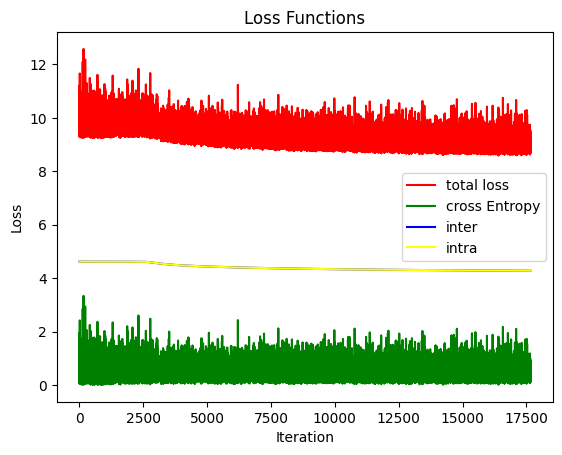

In [29]:
import matplotlib.pyplot as plt
plt.plot(iterations, totalloss, color='red', label='total loss')
plt.plot(iterations, cross, color='green', label='cross Entropy')
plt.plot(iterations, interl, color='blue', label='inter')
plt.plot(iterations, intral, color='yellow', label='intra')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Functions')
plt.legend()
plt.show()


In [30]:
print(hate_space_weights,not_hate_space_weights)

tensor([[ 0.3512],
        [-0.0657],
        [ 1.2647],
        [ 0.2842],
        [ 0.3192],
        [-0.1209],
        [ 0.2136],
        [ 0.5113],
        [ 0.2048],
        [ 0.1847],
        [ 0.2368]], device='cuda:0', requires_grad=True) tensor([[ 0.2811],
        [-0.0130],
        [ 0.6535],
        [ 0.0567],
        [ 0.4833],
        [-0.0024],
        [ 0.2997],
        [ 0.7456],
        [-0.2469],
        [ 0.3646],
        [-0.0527]], device='cuda:0', requires_grad=True)


In [31]:
print(hate_space,not_hate_space)

tensor([[-0.9874, -4.9623, -0.9972,  ...,  2.9603, -3.7720, -0.8533],
        [-1.0322,  3.2358, -0.5591,  ..., -1.3119, -0.9481,  0.2999],
        [-0.6068, -0.6256, -0.2093,  ...,  2.6185, -5.3850, -5.6030],
        ...,
        [ 4.4301, -2.8618, -2.9782,  ...,  1.4824, -1.3692,  0.3367],
        [ 2.1907,  2.2387, -4.2934,  ..., -0.7668,  1.2472,  0.5546],
        [ 1.6265, -3.1853,  0.9692,  ...,  1.5667, -2.6023,  0.0764]],
       device='cuda:0', requires_grad=True) tensor([[ 2.1089e+00,  4.9493e-01,  1.8950e+00,  ..., -1.5031e+00,
         -6.3753e-02,  3.6839e+00],
        [ 1.8754e+00, -9.3277e-01, -2.1923e+00,  ..., -2.0279e-01,
         -2.2740e+00, -1.4339e+00],
        [ 1.0407e+00,  4.8308e-01,  6.2661e-01,  ..., -1.0403e+00,
         -2.1796e-01,  3.6958e+00],
        ...,
        [ 3.3738e+01,  1.8076e+02,  1.5366e+02,  ...,  1.7570e+02,
          1.2272e+02,  1.5206e+02],
        [ 5.6722e-01, -4.2883e-01,  9.9996e-01,  ..., -8.8482e-01,
         -1.4296e+00,  2.9339e

In [32]:
def save_bert_model(model,tokenizer,params):
        output_dir = 'Saved/bert'
#         if(params['train_att']):
#             if(params['lambda_attn']>=1):
#                 params['lambda_attn']=int(params['lambda_attn'])

#             output_dir =  output_dir+str(params['supervised_layer_pos'])+'_'+str(params['num_supervised_heads'])+'_'+str(params['num_classes'])+'_'+str(params['lambda_attn'])+'/'
            
#         else:
#             output_dir=output_dir+'_'+str(params['num_classes'])+'/'
#         print(output_dir)
#         # Create output directory if needed
#         if not os.path.exists(output_dir):
#             os.makedirs(output_dir)

#         print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)

In [33]:
save_bert_model(model,tokenizer,model.parameters())

In [34]:
torch.save(hate_space, 'hatespace.pt')
torch.save(hate_space_weights, 'hatespace.pt_weights')
torch.save(not_hate_space, 'not_hatespace.pt')
torch.save(not_hate_space_weights, 'not_hatespace_weights.pt')